# Identify Fraudulent Credit Card Users

### It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

### The techniques applied here on one such dataset can help classify such fraudulent transactions 


# Importing libraries

In [109]:
import os
import io
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree

%matplotlib inline
plt.style.use('ggplot')

# Importing Credit Card dataset

In [110]:
current_dir = os.getcwd()
path_to_csv = os.path.abspath(os.path.join(current_dir, 'creditcard.csv'))
data = pd.read_csv(path_to_csv)


In [111]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Exploratory Data Analysis

In [112]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### Different types of variables in this dataset are - float64, Int64

In [113]:
data.loc[:, ['Time', 'Amount']].describe()

,Time,Amount
count,284807.000000,284807.000000
mean,94813.859575,88.349619
std,47488.145955,250.120109
min,0.000000,0.000000
25%,54201.500000,5.600000
50%,84692.000000,22.000000
75%,139320.500000,77.165000
max,172792.000000,25691.160000


# Identifying duplicate rows and dropping those, if any

In [114]:
print(f"Size of dataframe before dropping duplicate rows - {data.shape[0]}")
data.drop_duplicates(keep=False,inplace=True) 
print(f"Size of dataframe after dropping duplicate rows - {data.shape[0]}")

Size of dataframe before dropping duplicate rows - 284807
Size of dataframe after dropping duplicate rows - 282953


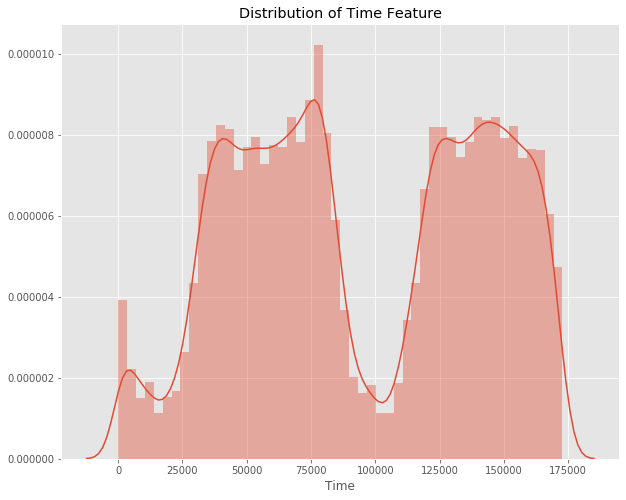

In [115]:
plt.figure(figsize=(10,8))
plt.title('Distribution of Time Feature')
sns.distplot(data.Time)

In [116]:
#fraud vs. normal transactions 
counts = data.Class.value_counts()
normal = counts[0]
fraudulent = counts[1]
perc_normal = (normal/(normal+fraudulent))*100
perc_fraudulent = (fraudulent/(normal+fraudulent))*100
print('There were {} non-fraudulent transactions ({:.3f}%) and {} fraudulent transactions ({:.3f}%)'.format(normal, perc_normal, fraudulent, perc_fraudulent))

There were 282493 non-fraudulent transactions (99.837%) and 460 fraudulent transactions (0.163%)


Text(0.5, 0, 'Class (0:Non-Fraudulent, 1:Fraudulent)')

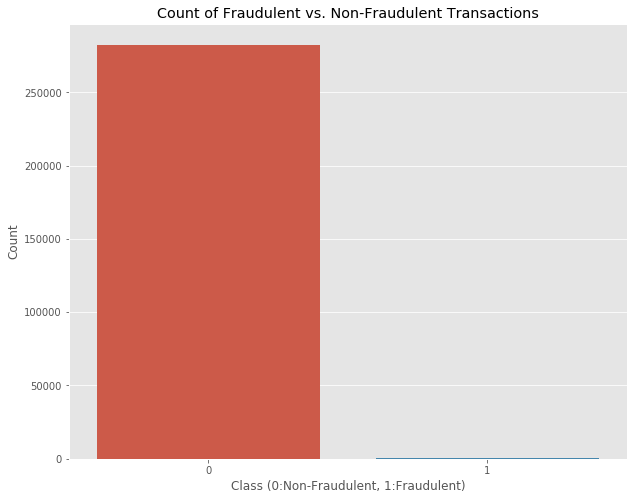

In [117]:
plt.figure(figsize=(10,8))
sns.barplot(x=counts.index, y=counts)
plt.title('Count of Fraudulent vs. Non-Fraudulent Transactions')
plt.ylabel('Count')
plt.xlabel('Class (0:Non-Fraudulent, 1:Fraudulent)')

## Training our model on the original dataset for creating a predictive model would lead to a lot of errors due to overfitting, misclassifying the fraudulent transactions as legitimate activity due to skewed data.

Text(0.5, 1, 'Heatmap of Correlation')

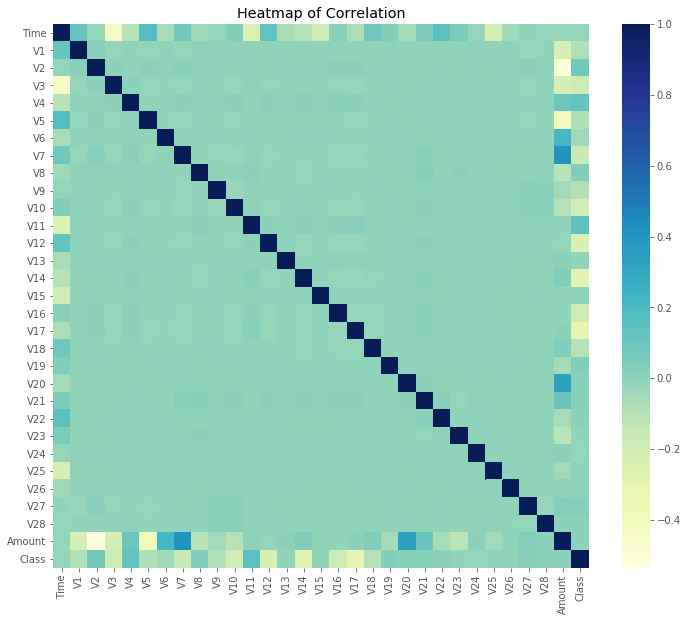

In [118]:
#heatmap
corr = data.corr()
plt.figure(figsize=(12,10))
heat = sns.heatmap(data=corr, cmap="YlGnBu")
plt.title('Heatmap of Correlation')

## The amount and time attributes are not scaled with the rest of the features in the dataset. These can be scaled using standard scaler

In [119]:
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

data['scaled_amount'] = rob_scaler.fit_transform(data['Amount'].values.reshape(-1,1))
data['scaled_time'] = rob_scaler.fit_transform(data['Time'].values.reshape(-1,1))

data.drop(['Time','Amount'], axis=1, inplace=True)
amount = data['scaled_amount']
time = data['scaled_time']

data.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
data.insert(0, 'amount', amount)
data.insert(1, 'time', time)

In [120]:
data.head()

,amount,time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.769551,-0.995569,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.267748,-0.995569,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.945369,-0.995557,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.407377,-0.995557,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.665419,-0.995545,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


# Sampling and redistributing dataset to avoid the class imbalance problem

In [121]:
data = data.sample(frac=1)

fraud_data = data.loc[data['Class']==1]
nfraud_data = data.loc[data['Class']==0][:460]

normal_distributed_df = pd.concat([fraud_data, nfraud_data])

# Shuffle dataframe rows
ndata = normal_distributed_df.sample(frac=1, random_state=42)

ndata.head()

,amount,time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
69498,-0.194121,-0.367332,0.385108,1.217620,-1.953872,2.087076,-1.144225,-0.576888,-2.582865,0.643230,...,0.380545,0.594623,0.372144,-0.310456,-0.624065,0.840216,-0.159452,0.599482,0.288916,1
86155,1.102329,-0.277336,-2.756007,0.683821,-1.390169,1.501887,-1.165614,-0.131207,-1.478741,-0.246922,...,-0.106945,0.320474,0.611027,0.174864,-0.502151,-0.174713,1.179242,-1.166315,0.821215,1
109886,0.207987,-0.154194,1.115731,-0.684801,1.306197,0.621690,-1.363514,0.436956,-1.117110,0.358254,...,-0.553034,-0.284518,-0.314523,0.113262,0.165047,0.104464,-0.397656,0.094755,0.035460,0
77682,-0.291181,-0.323703,-10.363049,4.543672,-9.795898,5.508003,-6.037156,-0.133493,-11.724346,-3.198346,...,0.924396,-2.457145,1.687257,0.977178,-0.543369,-0.289125,-0.107586,0.330642,0.163577,1
145974,-0.249723,0.030735,-0.526130,1.298682,-0.329471,-0.501426,1.032441,-0.567037,0.941052,-0.018977,...,0.169780,-0.018957,0.353581,-0.270092,0.528138,-0.118242,0.563114,0.490281,0.325420,0


Text(0.5, 1, 'Heatmap of Correlation')

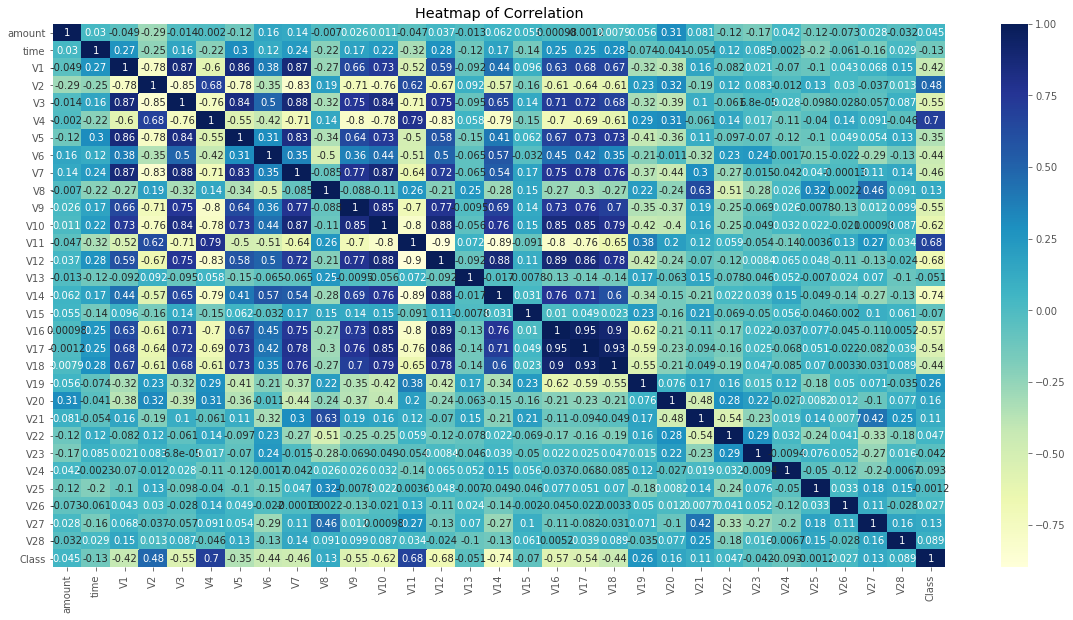

In [122]:
#heatmap
corr = ndata.corr()
plt.figure(figsize=(20,10))
heat = sns.heatmap(data=corr, cmap="YlGnBu", annot=True)
plt.title('Heatmap of Correlation')

# Train and test data split before model selection and fitting

In [123]:
X= ndata.iloc[:, ndata.columns != 'Class']
y = ndata.iloc[:, ndata.columns == 'Class']

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.25, random_state=1)

In [124]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Using Decision Tree Classifier

In [125]:
classifier = DecisionTreeClassifier(criterion = 'gini', random_state= 0 )
classifier.fit(X_train, y_train.ravel())

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [126]:
y_pre = classifier.predict(X_test)

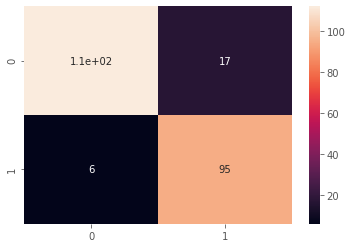

In [127]:
cm_grid = confusion_matrix(y_test,y_pre)
sns.heatmap(cm_grid, annot=True)

In [128]:
print(classification_report(y_test,y_pre))

              precision    recall  f1-score   support

           0       0.95      0.87      0.91       129
           1       0.85      0.94      0.89       101

    accuracy                           0.90       230
   macro avg       0.90      0.90      0.90       230
weighted avg       0.90      0.90      0.90       230



In [129]:
classifier.score(X_test,y_test)

0.9